# Imports

In [1]:
import tensorflow as tf
from typing import Optional, Tuple
import networkx as nx
import os, pickle
import numpy as np
import scipy.sparse as sp
import random
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from graph import  ZoneTransformer
from cluster_visualization import visualize_clusters
from typing import Iterable, Optional, Tuple
from sklearn.metrics import silhouette_score, adjusted_rand_score
import pandas as pd

2025-11-07 18:18:31.620918: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false --tf_xla_auto_jit=0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [3]:
print("GPUs:", tf.config.list_physical_devices('GPU'))

try:
    tf.keras.mixed_precision.set_global_policy('float32')
except Exception:
    pass

tf.config.optimizer.set_jit(False)
tf.config.run_functions_eagerly(False)


GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Feature Encoding

In [4]:
def print_attrs(path):
    with open(path, "rb") as f:
        g = pickle.load(f)
        for _, attrs in g.nodes(data=True):
            print(attrs)
            break

In [5]:
print_attrs("graphs/graph_match2499719_team1609.pkl")

{'zone_name': 'LEFT_WING_DEF_BOX', 'x_center': np.float64(3.0), 'y_center': np.float64(90.5), 'in_deg': 0, 'out_deg': 0, 'event_distribution': [0, 0, 0, 0], 'unique_players': 0, 'event_count': 0, 'most_common_event': None, 'role_distribution': [0, 0, 0, 0]}


In [6]:
def build_vocab(source):
    event_vocab, zone_vocab = set(), set()
    if isinstance(source, str):
        file_paths = [os.path.join(source, f) for f in os.listdir(source)
                      if os.path.isfile(os.path.join(source, f))]
    else:
        file_paths = list(source)

    for p in file_paths:
        with open(p, "rb") as f:
            g = pickle.load(f)
        for _, attrs in g.nodes(data=True):
            ev = attrs.get("most_common_event")
            zn = attrs.get("zone_name")
            if ev is not None: event_vocab.add(str(ev))
            if zn is not None: zone_vocab.add(str(zn))

    return sorted(event_vocab), sorted(zone_vocab)

event_vocab, zone_vocab = build_vocab('graphs')
print("Events: ", event_vocab)
print("Zones: ", zone_vocab)

Events:  ['DUEL', 'GOALKEEPER', 'PASS', 'SHOT']
Zones:  ['CENTER_ATT_PENALTY', 'CENTER_ATT_THIRD', 'CENTER_DEF_BOX', 'CENTER_DEF_PENALTY', 'CENTER_DEF_THIRD', 'CENTER_DEF_THIRD_DEEP', 'CENTER_MID_THIRD_ATT', 'CENTER_MID_THIRD_DEF', 'LEFT_HALF_ATT_PENALTY', 'LEFT_HALF_ATT_THIRD', 'LEFT_HALF_DEF_BOX', 'LEFT_HALF_DEF_PENALTY', 'LEFT_HALF_DEF_THIRD', 'LEFT_HALF_DEF_THIRD_DEEP', 'LEFT_HALF_MID_THIRD_ATT', 'LEFT_HALF_MID_THIRD_DEF', 'LEFT_WING_ATT_PENALTY', 'LEFT_WING_ATT_THIRD', 'LEFT_WING_DEF_BOX', 'LEFT_WING_DEF_PENALTY', 'LEFT_WING_DEF_THIRD', 'LEFT_WING_DEF_THIRD_DEEP', 'LEFT_WING_MID_THIRD_ATT', 'LEFT_WING_MID_THIRD_DEF', 'OUTSIDE', 'RIGHT_HALF_ATT_PENALTY', 'RIGHT_HALF_ATT_THIRD', 'RIGHT_HALF_DEF_BOX', 'RIGHT_HALF_DEF_PENALTY', 'RIGHT_HALF_DEF_THIRD', 'RIGHT_HALF_DEF_THIRD_DEEP', 'RIGHT_HALF_MID_THIRD_ATT', 'RIGHT_HALF_MID_THIRD_DEF', 'RIGHT_WING_ATT_PENALTY', 'RIGHT_WING_ATT_THIRD', 'RIGHT_WING_DEF_BOX', 'RIGHT_WING_DEF_PENALTY', 'RIGHT_WING_DEF_THIRD', 'RIGHT_WING_DEF_THIRD_DEEP', '

In [7]:
def encode_node_attributes(attrs, event_vocab, zone_vocab):
    event_onehot = np.zeros(len(event_vocab), dtype=np.float32)
    if attrs["most_common_event"] in event_vocab:
        event_onehot[event_vocab.index(attrs["most_common_event"])] = 1.0
    zone_onehot = np.zeros(len(zone_vocab), dtype=np.float32)
    if attrs["zone_name"] in zone_vocab:
        zone_onehot[zone_vocab.index(attrs["zone_name"])] = 1.0

    numeric = np.array([attrs["event_count"], attrs["unique_players"]], dtype=np.float32)
    role = np.array(attrs["role_distribution"], dtype=np.float32)

    return np.concatenate([numeric, role, event_onehot, zone_onehot])

# Helpers

In [8]:
def normalize_adj(adj):
    adj = adj + sp.eye(adj.shape[0])
    rowsum = np.array(adj.sum(1)).flatten()
    d_inv_sqrt = np.power(rowsum, -0.5, where=rowsum>0)
    D_inv_sqrt = sp.diags(d_inv_sqrt)

    return D_inv_sqrt @ adj @ D_inv_sqrt

def scipy_to_tf_sparse(mat):
    mat = mat.tocoo()
    indices = np.vstack((mat.row, mat.col)).T

    return tf.SparseTensor(indices, mat.data.astype(np.float32), mat.shape)

In [9]:
def get_graph_embedding(path, encoder, event_vocab, zone_vocab):
    
    A_tf, A_dense, X = load_graph(path, event_vocab, zone_vocab)

    with open(path, "rb") as file:
        G = pickle.load(file)
    node_order = list(G.nodes)

    Z = encoder((X, A_tf), training=False).numpy()
    
    return Z, node_order, G

In [10]:
def cluster_graph_embedding(Z: np.ndarray, n_clusters: Optional[int] = None, random_state: int = 42):
    n = Z.shape[0]
    if n_clusters is None:
        k = max(2, min(12, int(np.ceil(np.sqrt(max(n, 1))/1.5))))
    else:
        k = int(n_clusters)
    km = KMeans(n_clusters=k, n_init=10, random_state=random_state)
    clusters = km.fit_predict(Z)
    return clusters


In [11]:

def visualize_clusters_on_graph(G: nx.Graph, labels: np.ndarray, layout: str = "spring", title: Optional[str] = None, node_size: int = 140):
    nodes = list(G.nodes())
    if len(labels) != len(nodes):
        raise ValueError("labels length must equal number of nodes in G")

    if layout == "kamada":
        pos = nx.kamada_kawai_layout(G)
    elif layout == "embedding":
        raise ValueError("Use 'embedding' layout via visualize_with_embedding(...) below.")
    else:
        pos = nx.spring_layout(G, seed=42)

    n_clusters = int(labels.max()) + 1 if len(labels) else 1
    cmap = plt.get_cmap("tab20" if n_clusters > 10 else "tab10", max(n_clusters, 1))
    colors = [cmap(int(c)) for c in labels]

    plt.figure(figsize=(8, 6))
    nx.draw_networkx_edges(G, pos, alpha=0.25, width=0.8)
    nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=node_size, edgecolors="k", linewidths=0.3)

    zone_labels = {}
    for n in nodes:
        zname = G.nodes[n].get("zone_name")
        if isinstance(zname, str) and zname:
            zone_labels[n] = zname
    if zone_labels:
        nx.draw_networkx_labels(G, pos, labels=zone_labels, font_size=7)

    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()


# Data Loading

In [12]:
def load_data(directory, event_vocab, zone_vocab):
    file_name = os.listdir(directory)[0]
    with open(os.path.join(directory, file_name), 'rb') as f:
        graph_data = pickle.load(f)
    adj = nx.adjacency_matrix(graph_data)
    features = [encode_node_attributes(attrs, event_vocab, zone_vocab)
                for _, attrs in graph_data.nodes(data=True)]
    X = np.vstack(features)

    return adj, X

In [13]:
def list_graph_paths(directory):
    paths = [os.path.join(directory, f) for f in os.listdir(directory)
             if os.path.isfile(os.path.join(directory, f))]
    paths.sort()
    return paths

In [14]:
def load_graph(path, event_vocab, zone_vocab):
    with open(path, "rb") as f:
        graph = pickle.load(f)
    A = nx.adjacency_matrix(graph)
    X = np.stack([
        encode_node_attributes(attrs, event_vocab, zone_vocab)
        for _, attrs in graph.nodes(data=True)
    ]).astype(np.float32)

    A_norm = normalize_adj(A)
    A_tf = scipy_to_tf_sparse(A_norm)
    A_dense = np.asarray(A_norm.todense(), dtype=np.float32)

    return A_tf, A_dense, X

# Model

In [15]:
class GraphConvolution(tf.keras.layers.Layer):
    def __init__(self, units: int, activation: Optional[str] = "relu", dropout: float = 0.0, use_bias: bool = True, name: str = None):
        super().__init__(name=name)
        self.units = units
        self.use_bias = use_bias
        self.activation = tf.keras.activations.get(activation)
        self.dropout = tf.keras.layers.Dropout(dropout) if dropout and dropout > 0.0 else None

    def build(self, input_shape: Tuple[Tuple[int, int], Tuple[int, int]]):
        x_shape = input_shape[0]
        in_features = int(x_shape[-1])
        self.W = self.add_weight(
        name="weight",
        shape=(in_features, self.units),
        initializer="glorot_uniform",
        trainable=True
        )
        if self.use_bias:
            self.b = self.add_weight(
            name="bias",
            shape=(self.units,),
            initializer="zeros",
            trainable=True
        )
        else:
            self.b = None
        super().build(input_shape)

    def call(self, inputs, training: bool = False):
        x, A_hat = inputs
        if self.dropout is not None and training:
            x = self.dropout(x, training=training)
        support = tf.matmul(x, self.W)
        Z = tf.sparse.sparse_dense_matmul(A_hat, support)
        if self.b is not None: Z = Z + self.b

        return self.activation(Z) if self.activation is not None else Z

In [16]:
class GAEEncoder(tf.keras.Model):
    def __init__(self, input_dim: int, hidden_dim: int, latent_dim: int, dropout: float = 0.0):
        super().__init__()
        self.gcn_hidden = GraphConvolution(hidden_dim, activation="relu", dropout=dropout, name="gcn_hidden")
        self.gcn_mu = GraphConvolution(latent_dim, activation=None, dropout=dropout, name="gcn_mu")

    def call(self, inputs, training: bool = False):
        X, A_hat = inputs
        H = self.gcn_hidden((X, A_hat), training=training)
        Z = self.gcn_mu((H, A_hat), training=training)

        return Z

In [17]:
class GAEFeatureDecoder(tf.keras.Model):
    def __init__(self, out_units, hidden_units: int = 64, activation: str = "relu", name: str = "Decoder"):
        super().__init__(name=name)
        self.d1 = tf.keras.layers.Dense(hidden_units, activation=activation)
        self.out = tf.keras.layers.Dense(out_units, activation=None)

    def call(self, Z, training=False):
        h = self.d1(Z, training=training)
        X_hat = self.out(h, training=training)

        return X_hat

# Training

In [18]:
sample_path = list_graph_paths("graphs")[0]
_, _, X_sample = load_graph(sample_path, event_vocab, zone_vocab)
input_dim = X_sample.shape[1]
encoder = GAEEncoder(input_dim=input_dim, hidden_dim=32, latent_dim=8, dropout=0.1)
feature_dim = int(X_sample.shape[1])
decoder = GAEFeatureDecoder(out_units=feature_dim, hidden_units=64)

I0000 00:00:1762535987.445089     966 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [19]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
mse = tf.keras.losses.MeanSquaredError()

In [20]:
def train_step(X, A_tf, A_dense):
    with tf.GradientTape() as tape:
        Z = encoder((X, A_tf), training=True)
        X_hat = decoder(Z, training=True)
        if X_hat.shape[-1] != X.shape[-1]:
            decoder.out = tf.keras.layers.Dense(int(X.shape[-1]), activation=None)
            X_hat = decoder(Z, training=True)
        loss = mse(X, X_hat)
    
    vars = encoder.trainable_variables + decoder.trainable_variables
    grads = tape.gradient(loss, vars)
    optimizer.apply_gradients(zip(grads, vars))

    return loss

In [21]:
train_paths = list_graph_paths("graphs")
print(f"Train graphs: {len(train_paths)}")

Train graphs: 112


In [22]:
for epoch in range(1, 30):
    train_losses = []
    for path in train_paths:
        A_tf, A_dense, X = load_graph(path, event_vocab, zone_vocab)
        loss = train_step(X, A_tf, A_dense)
        train_losses.append(loss.numpy())

    if epoch % 5 == 0 or epoch == 29:
        print(f"Epoch {epoch}, Train Loss: {tf.reduce_mean(train_losses):.4f}")

Epoch 5, Train Loss: 0.9760
Epoch 10, Train Loss: 0.8497
Epoch 15, Train Loss: 0.7357
Epoch 20, Train Loss: 0.7481
Epoch 25, Train Loss: 0.5951
Epoch 29, Train Loss: 0.5960


# Clustering

In [23]:
path = 'graphs/graph_match2499719_team1609.pkl'
Z, node_order, G = get_graph_embedding(path, encoder, event_vocab, zone_vocab)

path2 = 'graphs/graph_match2500080_team1609.pkl'
Z2, node_order2, G2 = get_graph_embedding(path, encoder, event_vocab, zone_vocab)

clusters = cluster_graph_embedding(Z, 5, random.seed(42))
print(clusters)

[1 1 4 1 1 1 4 2 1 4 2 0 0 2 4 2 0 0 0 2 0 3 3 3 0 0 0 0 3 0 4 1 4 4 2 1 1
 1 1 1 0]


# Visualization

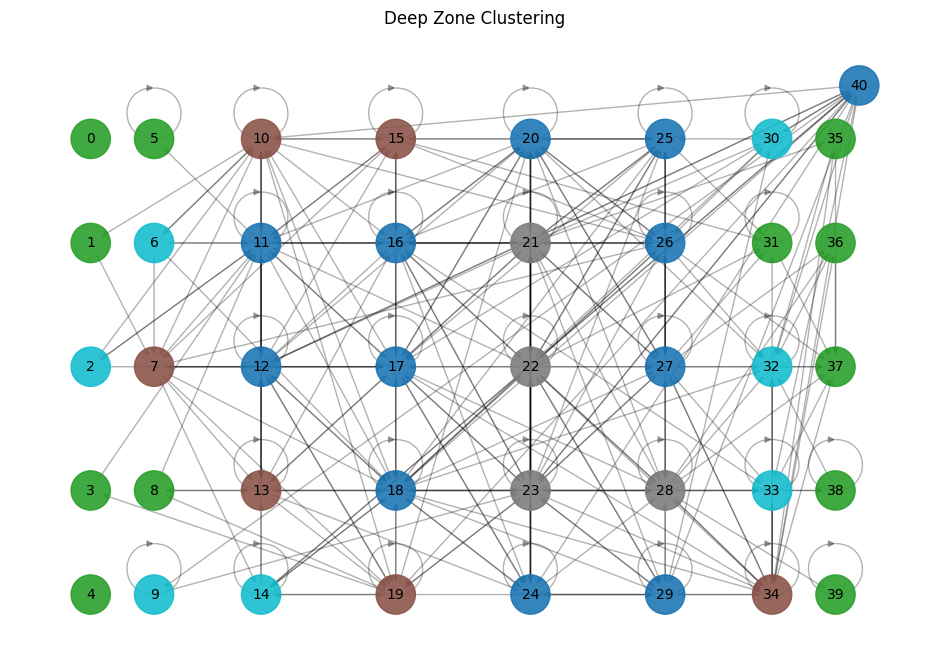

In [24]:
zt = ZoneTransformer()
visualize_clusters(G, Z, clusters, zt)

# Average Team Clusters

In [25]:
# Creating team match lists 

team1609_matches = []
team1612_matches = []
team1625_matches = []

for path in train_paths:
    if 'team1609' in path:
        team1609_matches.append(path)
    elif 'team1612' in path:
        team1625_matches.append(path)
    elif 'team1625' in path:
        team1612_matches.append(path)

# Team 1609

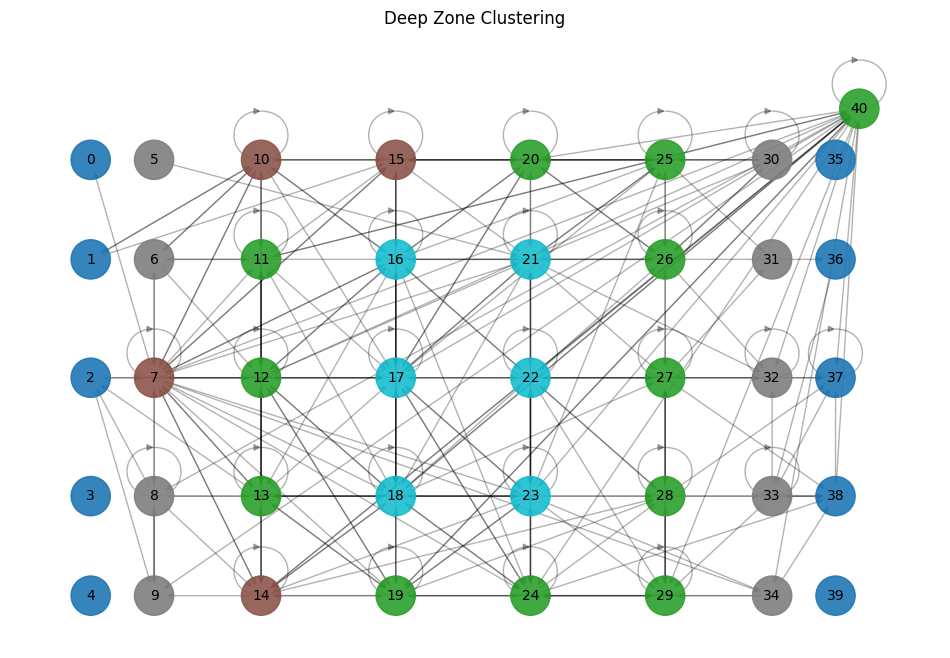

In [34]:
emb_list = []
for match_path in team1609_matches:
    Z, node_order, G = get_graph_embedding(match_path, encoder, event_vocab, zone_vocab)
    emb_list.append(Z)

emb_stack = np.stack(emb_list, axis=0)
emb_mean = emb_stack.mean(axis=0)

clusters = cluster_graph_embedding(emb_mean, 5, random.seed(42))

visualize_clusters(G, emb_mean, clusters, zt)


# Team 1612

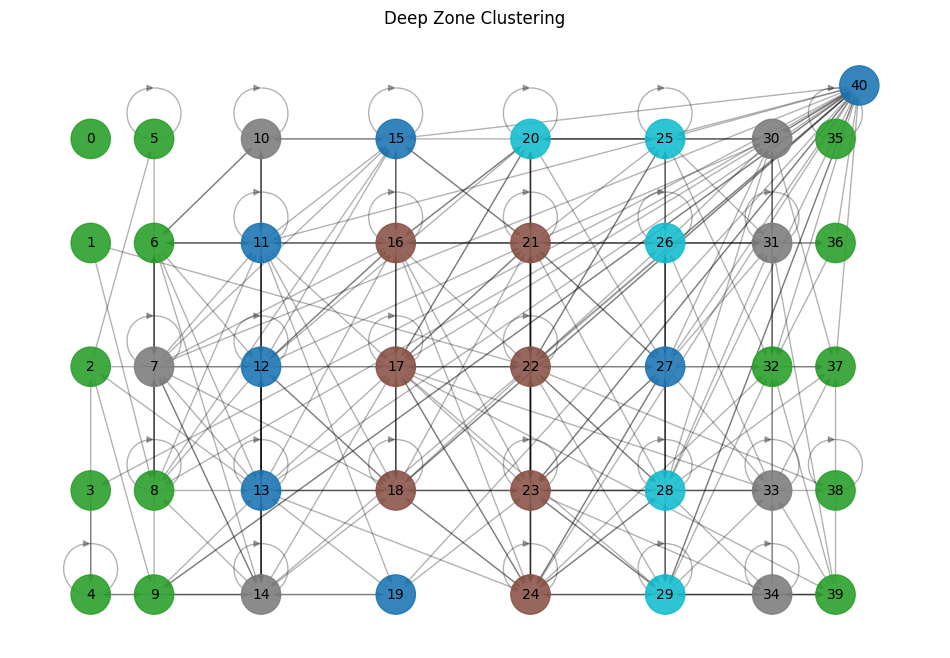

In [35]:
emb_list = []
for match_path in team1612_matches:
    Z, node_order, G = get_graph_embedding(match_path, encoder, event_vocab, zone_vocab)
    emb_list.append(Z)

emb_stack = np.stack(emb_list, axis=0)
emb_mean = emb_stack.mean(axis=0)

clusters = cluster_graph_embedding(emb_mean, 5, random.seed(42))

visualize_clusters(G, emb_mean, clusters, zt)


# Team 1625

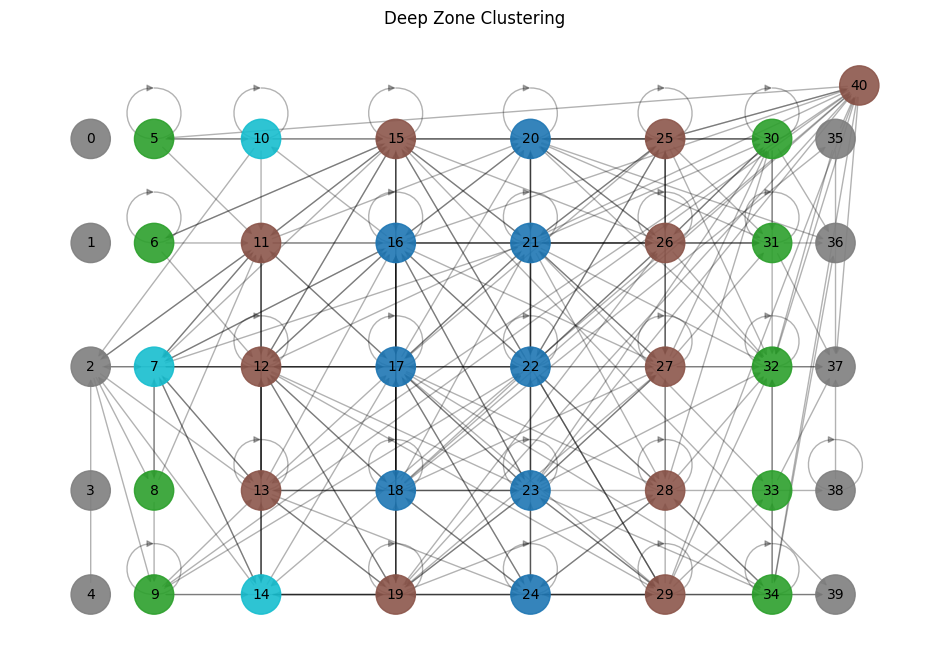

In [36]:
emb_list = []
for match_path in team1625_matches:
    Z, node_order, G = get_graph_embedding(match_path, encoder, event_vocab, zone_vocab)
    emb_list.append(Z)

emb_stack = np.stack(emb_list, axis=0)
emb_mean = emb_stack.mean(axis=0)

clusters = cluster_graph_embedding(emb_mean, 5, random.seed(42))

visualize_clusters(G, emb_mean, clusters, zt)


# Evaluation Functions

In [102]:
def compute_silhouette(embeddings: np.ndarray, clusters: Iterable[int], metric: str = "euclidean") -> float:
    embeddings = np.asarray(embeddings)
    clusters = np.asarray(list(clusters))
    if embeddings.ndim != 2:
        raise ValueError("embeddings must be 2D (n_samples, n_features)")
    if len(embeddings) != len(clusters):
        raise ValueError("embeddings and clusters must have the same length")
    unique = np.unique(clusters)
    if len(unique) < 2 or len(unique) == len(clusters):
        return float("nan")
    return float(silhouette_score(embeddings, clusters, metric=metric))


def compute_modularity(G: nx.Graph, clusters: Iterable[int], node_key: Optional[str] = None) -> float:
    from networkx.algorithms.community.quality import modularity as nx_modularity

    if node_key is not None:
        node_to_label = {}
        for n, data in G.nodes(data=True):
            key_val = data.get(node_key, n)
            node_to_label[n] = clusters[key_val]
    else:
        node_list = list(G.nodes())
        clusters = list(clusters)
        if len(node_list) != len(clusters):
            raise ValueError("When node_key is None, clusters must align with list(G.nodes())")
        node_to_label = {n: c for n, c in zip(node_list, clusters)}

    communities = {}
    for n, c in node_to_label.items():
        communities.setdefault(c, set()).add(n)
    partition = list(communities.values())
    if len(partition) < 2:
        return float("nan")
    return float(nx_modularity(G, partition))

In [103]:
print(compute_silhouette(Z, clusters))
print(compute_modularity(G, clusters))

0.5652451515197754
0.13412122358768844


# Silhouette Scores

In [105]:
t09s_scores = []
for path in team1609_matches:
    Z, node_order, G = get_graph_embedding(path, encoder, event_vocab, zone_vocab)
    clusters = cluster_graph_embedding(Z, 5, random.seed(42))
    t09s_score = compute_silhouette(Z, clusters)
    t09s_scores.append(t09s_score)

t12s_scores = []
for path in team1612_matches:
    Z, node_order, G = get_graph_embedding(path, encoder, event_vocab, zone_vocab)
    clusters = cluster_graph_embedding(Z, 5, random.seed(42))
    t12s_score = compute_silhouette(Z, clusters)
    t12s_scores.append(t12s_score)

t25s_scores = []
for path in team1625_matches:
    Z, node_order, G = get_graph_embedding(path, encoder, event_vocab, zone_vocab)
    clusters = cluster_graph_embedding(Z, 5, random.seed(42))
    t25s_score = compute_silhouette(Z, clusters)
    t25s_scores.append(t25s_score)

print("--------------------")
print("Team 1609 Silhouette Scores")
print("--------------------")
print("Mean: ", np.mean(t09s_scores))
print("Std: ", np.std(t09s_scores))
print("--------------------")
print("Team 1612 Silhouette Scores")
print("--------------------")
print("Mean: ", np.mean(t12s_scores))
print("Std: ", np.std(t12s_scores))
print("--------------------")
print("Team 1625 Silhouette Scores")
print("--------------------")
print("Mean:", np.mean(t25s_scores))
print("Std: ", np.std(t25s_scores))

--------------------
Team 1609 Silhouette Scores
--------------------
Mean:  0.5482880802530992
Std:  0.03837590872233743
--------------------
Team 1612 Silhouette Scores
--------------------
Mean:  0.5612433866874592
Std:  0.03932154647577168
--------------------
Team 1625 Silhouette Scores
--------------------
Mean: 0.5475387516859416
Std:  0.03513923476833005


# Modularity Scores

In [106]:
t09m_scores = []
for path in team1609_matches:
    Z, node_order, G = get_graph_embedding(path, encoder, event_vocab, zone_vocab)
    clusters = cluster_graph_embedding(Z, 5, random.seed(42))
    t09m_score = compute_modularity(G, clusters)
    t09m_scores.append(t09m_score)

t12m_scores = []
for path in team1612_matches:
    Z, node_order, G = get_graph_embedding(path, encoder, event_vocab, zone_vocab)
    clusters = cluster_graph_embedding(Z, 5, random.seed(42))
    t12m_score = compute_modularity(G, clusters)
    t12m_scores.append(t12m_score)

t25m_scores = []
for path in team1625_matches:
    Z, node_order, G = get_graph_embedding(path, encoder, event_vocab, zone_vocab)
    clusters = cluster_graph_embedding(Z, 5, random.seed(42))
    t25m_score = compute_modularity(G, clusters)
    t25m_scores.append(t25m_score)

print("--------------------")
print("Team 1609 Modularity Scores")
print("--------------------")
print("Mean: ", np.mean(t09m_scores))
print("Std: ", np.std(t09m_scores))
print("--------------------")
print("Team 1612 Modularity Scores")
print("--------------------")
print("Mean: ", np.mean(t12m_scores))
print("Std: ", np.std(t12m_scores))
print("--------------------")
print("Team 1625 Modularity Scores")
print("--------------------")
print("Mean:", np.mean(t25m_scores))
print("Std: ", np.std(t25m_scores))

--------------------
Team 1609 Modularity Scores
--------------------
Mean:  0.15017500478230952
Std:  0.03891593219943233
--------------------
Team 1612 Modularity Scores
--------------------
Mean:  0.16580070793766763
Std:  0.03557784014849556
--------------------
Team 1625 Modularity Scores
--------------------
Mean: 0.13845695068260183
Std:  0.039327939847893456


In [107]:
labels_per_match = []
for path in team1609_matches:
    Z, node_order, G = get_graph_embedding(path, encoder, event_vocab, zone_vocab)
    clusters = cluster_graph_embedding(Z, n_clusters=5, random_state=42)
    labels_per_match.append(np.asarray(clusters))

n = len(labels_per_match)
t09_pairwise_ari = []
for i in range(n):
    for j in range(i, n):
        if i == j:
            continue
        else:
            ari = adjusted_rand_score(labels_per_match[i], labels_per_match[j])
            t09_pairwise_ari.append(ari)

labels_per_match = []
for path in team1612_matches:
    Z, node_order, G = get_graph_embedding(path, encoder, event_vocab, zone_vocab)
    clusters = cluster_graph_embedding(Z, n_clusters=5, random_state=42)
    labels_per_match.append(np.asarray(clusters))

n = len(labels_per_match)
t12_pairwise_ari = []
for i in range(n):
    for j in range(i, n):
        if i == j:
            continue
        else:
            ari = adjusted_rand_score(labels_per_match[i], labels_per_match[j])
            t12_pairwise_ari.append(ari)

labels_per_match = []
for path in team1625_matches:
    Z, node_order, G = get_graph_embedding(path, encoder, event_vocab, zone_vocab)
    clusters = cluster_graph_embedding(Z, n_clusters=5, random_state=42)
    labels_per_match.append(np.asarray(clusters))

n = len(labels_per_match)
t25_pairwise_ari = []
for i in range(n):
    for j in range(i, n):
        if i == j:
            continue
        else:
            ari = adjusted_rand_score(labels_per_match[i], labels_per_match[j])
            t25_pairwise_ari.append(ari)

print("--------------------")
print("Team 1609 Adjusted Random Index")
print("--------------------")
print("Mean: ", np.mean(t09_pairwise_ari))
print("Std: ", np.std(t09_pairwise_ari))
print("--------------------")
print("Team 1612 Adjusted Random Index")
print("--------------------")
print("Mean: ", np.mean(t12_pairwise_ari))
print("Std: ", np.std(t12_pairwise_ari))
print("--------------------")
print("Team 1625 Adjusted Random Index")
print("--------------------")
print("Mean:", np.mean(t25_pairwise_ari))
print("Std: ", np.std(t25_pairwise_ari))

--------------------
Team 1609 Adjusted Random Index
--------------------
Mean:  0.2912890906380912
Std:  0.08377870741227457
--------------------
Team 1612 Adjusted Random Index
--------------------
Mean:  0.2983107621842206
Std:  0.1075096289393312
--------------------
Team 1625 Adjusted Random Index
--------------------
Mean: 0.2884490201641804
Std:  0.08462647822007316


In [109]:
def stats(arr):
    a = np.asarray(arr, dtype=float)
    return np.nanmean(a), np.nanstd(a)

teams = ["1609", "1612", "1625"]

print(f"{'Team':<12} {'Silhouette':>20} {'Modularity':>20} {'ARI':>20}")
print("-" * 75)

for t in teams:
    s_mean, s_std = stats(globals()[f"t{t[-2:]}s_scores"])
    m_mean, m_std = stats(globals()[f"t{t[-2:]}m_scores"])
    a_mean, a_std = stats(globals()[f"t{t[-2:]}_pairwise_ari"])
    print(f"Team {t:<6} {s_mean:10.4f} ± {s_std:<8.4f} {m_mean:10.4f} ± {m_std:<8.4f} {a_mean:10.4f} ± {a_std:<8.4f}")

print()


Team                   Silhouette           Modularity                  ARI
---------------------------------------------------------------------------
Team 1609       0.5483 ± 0.0384       0.1502 ± 0.0389       0.2913 ± 0.0838  
Team 1612       0.5612 ± 0.0393       0.1658 ± 0.0356       0.2983 ± 0.1075  
Team 1625       0.5475 ± 0.0351       0.1385 ± 0.0393       0.2884 ± 0.0846  

